# 1. txt merge

In [1]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [2]:
import pandas as pd
import numpy as np
import pyspark.sql.types as T
import pyspark.sql.functions as F

In [ ]:
import glob
import os

input_file = r'./data/txt'
output_file = r'./data2/bus_per_date.csv'

allFile_list = glob.glob(os.path.join(input_file, 'bus_per_date*'))
print(allFile_list)
allData = []
for file in allFile_list:
    df = pd.read_csv(file, encoding="euc-kr",names = ["사용일자","노선번호","노선명","버스정류장ARS번호","역명","승차총승객수","하차총승객수","등록일자"], skiprows=[0])
    allData.append(df)

dataCombine = pd.concat(allData, axis=0, ignore_index=True)
dataCombine.to_csv(output_file,encoding='euc-kr', index=False)

In [3]:
df = spark.read.csv('./data/bus_per_date.csv', encoding="euc-kr", header=True)
df.show()

+--------+--------+------------------------------+-----------------+----------------------+------------+------------+--------+
|사용일자|노선번호|                        노선명|버스정류장ARS번호|                  역명|승차총승객수|하차총승객수|등록일자|
+--------+--------+------------------------------+-----------------+----------------------+------------+------------+--------+
|20180101|     100|        100번(하계동~용산구청)|            11428|          한성여객종점|          12|           4|20180104|
|20180101|     100|        100번(하계동~용산구청)|            11387|        노원평생학습관|          11|           0|20180104|
|20180101|     100|        100번(하계동~용산구청)|            11373|                중계역|          15|           1|20180104|
|20180101|     100|        100번(하계동~용산구청)|            11381|         중계시영4단지|          97|          13|20180104|
|20180101|     100|        100번(하계동~용산구청)|            11311|              인덕대학|          93|          79|20180104|
|20180101|     100|        100번(하계동~용산구청)|            01198|                원남동|      

In [4]:
#csv 확인
df.select("사용일자").distinct().collect()

[Row(사용일자='20180424'),
 Row(사용일자='20180516'),
 Row(사용일자='20181112'),
 Row(사용일자='20190112'),
 Row(사용일자='20200218'),
 Row(사용일자='20200413'),
 Row(사용일자='20200714'),
 Row(사용일자='20201015'),
 Row(사용일자='20210202'),
 Row(사용일자='20210607'),
 Row(사용일자='20210611'),
 Row(사용일자='20210712'),
 Row(사용일자='20181212'),
 Row(사용일자='20190111'),
 Row(사용일자='20190305'),
 Row(사용일자='20191005'),
 Row(사용일자='20200314'),
 Row(사용일자='20201011'),
 Row(사용일자='20211010'),
 Row(사용일자='20210714'),
 Row(사용일자='20210729'),
 Row(사용일자='20180402'),
 Row(사용일자='20180705'),
 Row(사용일자='20181115'),
 Row(사용일자='20200311'),
 Row(사용일자='20210211'),
 Row(사용일자='20180904'),
 Row(사용일자='20181031'),
 Row(사용일자='20181103'),
 Row(사용일자='20181207'),
 Row(사용일자='20190113'),
 Row(사용일자='20190420'),
 Row(사용일자='20191116'),
 Row(사용일자='20200821'),
 Row(사용일자='20200902'),
 Row(사용일자='20211022'),
 Row(사용일자='20210119'),
 Row(사용일자='20210523'),
 Row(사용일자='20181011'),
 Row(사용일자='20190208'),
 Row(사용일자='20190417'),
 Row(사용일자='20201016'),
 Row(사용일자='20210603'),
 Row(사용일자='

## 2. 데이터 전처리

In [6]:
#데이터 타입 확인
df.printSchema()

root
 |-- 사용일자: string (nullable = true)
 |-- 노선번호: string (nullable = true)
 |-- 노선명: string (nullable = true)
 |-- 버스정류장ARS번호: string (nullable = true)
 |-- 역명: string (nullable = true)
 |-- 승차총승객수: string (nullable = true)
 |-- 하차총승객수: string (nullable = true)
 |-- 등록일자: string (nullable = true)



In [7]:
#정류장 역번호 개수
df.select('버스정류장ARS번호').distinct().count()

13368

In [8]:
#정류장 역명 개수
df.select('역명').distinct().count()

9134

In [9]:
#버스 대수
df.select('노선명').distinct().count()

745

In [10]:
#버스 번호 확인
df.select('노선번호').distinct().count()

649

In [11]:
#전체 줄 개수
df.count()

53553555

In [13]:
#컬럼 데이터타입 변환
df = df.withColumn('사용일자',F.to_date(F.col("사용일자"),"yyyyMMdd"))\
.withColumn('승차총승객수',F.col('승차총승객수').cast(T.IntegerType()))\
.withColumn('하차총승객수',F.col('하차총승객수').cast(T.IntegerType()))

In [14]:
#데이터 타입 확인
df.printSchema()

root
 |-- 사용일자: date (nullable = true)
 |-- 노선번호: string (nullable = true)
 |-- 노선명: string (nullable = true)
 |-- 버스정류장ARS번호: string (nullable = true)
 |-- 역명: string (nullable = true)
 |-- 승차총승객수: integer (nullable = true)
 |-- 하차총승객수: integer (nullable = true)
 |-- 등록일자: string (nullable = true)



In [15]:
#승차승객수 Null 값 확인
df.where(F.col('승차총승객수').isNull()==True).count()

0

In [16]:
#승차 승객 수 이상치 확인
df.where(F.col('승차총승객수')<0).count()

0

In [17]:
#하차승객수 Null 값 확인
df.where(F.col('하차총승객수').isNull()==True).count()

0

In [18]:
#하차승객 수 이상치 확인
df.where(F.col('승차총승객수')<0).count()

0

In [19]:
#이용객 수 컬럼 생성(승차총승객수 + 하차총승객수)
df = df.withColumn('이용객수', sum([df[col] for col in ["`승차총승객수`","`하차총승객수`"]]))
df.show()

+----------+--------+------------------------------+-----------------+----------------------+------------+------------+--------+--------+
|  사용일자|노선번호|                        노선명|버스정류장ARS번호|                  역명|승차총승객수|하차총승객수|등록일자|이용객수|
+----------+--------+------------------------------+-----------------+----------------------+------------+------------+--------+--------+
|2018-01-01|     100|        100번(하계동~용산구청)|            11428|          한성여객종점|          12|           4|20180104|      16|
|2018-01-01|     100|        100번(하계동~용산구청)|            11387|        노원평생학습관|          11|           0|20180104|      11|
|2018-01-01|     100|        100번(하계동~용산구청)|            11373|                중계역|          15|           1|20180104|      16|
|2018-01-01|     100|        100번(하계동~용산구청)|            11381|         중계시영4단지|          97|          13|20180104|     110|
|2018-01-01|     100|        100번(하계동~용산구청)|            11311|              인덕대학|          93|          79|20180104|     172|
|2

In [20]:
#필요없는 컬럼 제거
df = df.drop('등록일자')
df.show()

+----------+--------+------------------------------+-----------------+----------------------+------------+------------+--------+
|  사용일자|노선번호|                        노선명|버스정류장ARS번호|                  역명|승차총승객수|하차총승객수|이용객수|
+----------+--------+------------------------------+-----------------+----------------------+------------+------------+--------+
|2018-01-01|     100|        100번(하계동~용산구청)|            11428|          한성여객종점|          12|           4|      16|
|2018-01-01|     100|        100번(하계동~용산구청)|            11387|        노원평생학습관|          11|           0|      11|
|2018-01-01|     100|        100번(하계동~용산구청)|            11373|                중계역|          15|           1|      16|
|2018-01-01|     100|        100번(하계동~용산구청)|            11381|         중계시영4단지|          97|          13|     110|
|2018-01-01|     100|        100번(하계동~용산구청)|            11311|              인덕대학|          93|          79|     172|
|2018-01-01|     100|        100번(하계동~용산구청)|            01198|        

In [21]:
#parquet으로 저장
df.write.parquet("bus_per_date")

## 3. 데이터 분석

In [22]:
pq = spark.read.parquet('bus_per_date')
pq.show()

+----------+--------+---------------------+-----------------+-----------------------------+------------+------------+--------+
|  사용일자|노선번호|               노선명|버스정류장ARS번호|                         역명|승차총승객수|하차총승객수|이용객수|
+----------+--------+---------------------+-----------------+-----------------------------+------------+------------+--------+
|2018-09-26|    5615|  5615번(난곡~여의도)|            21210|               난우중학교입구|          85|           1|      86|
|2018-09-26|    5528|5528번(가산동~사당역)|            18106|             가산디지털단지역|          16|         171|     187|
|2018-09-26|    5528|5528번(가산동~사당역)|            17231|               구일우성아파트|          16|          16|      32|
|2018-09-26|    5528|5528번(가산동~사당역)|            17232|               구일우성아파트|          20|         120|     140|
|2018-09-26|    5528|5528번(가산동~사당역)|            17237|                구로1동우체국|          70|          56|     126|
|2018-09-26|    5528|5528번(가산동~사당역)|            18104|         디지털3단지.영창실업|           2| 

In [24]:
pq.printSchema()

root
 |-- 사용일자: date (nullable = true)
 |-- 노선번호: string (nullable = true)
 |-- 노선명: string (nullable = true)
 |-- 버스정류장ARS번호: string (nullable = true)
 |-- 역명: string (nullable = true)
 |-- 승차총승객수: integer (nullable = true)
 |-- 하차총승객수: integer (nullable = true)
 |-- 이용객수: integer (nullable = true)



In [25]:
pq.count()

53553555

In [99]:
#일별이용자수를 구하기
user_per_date = df.groupby('`사용일자`').agg(F.sum('`승차총승객수`').alias('일별이용자수')).orderBy(F.asc('`사용일자`'))

In [100]:
#그래프를 보기 위해 판다스로 변환
user_per_date = user_per_date.select("*").toPandas()

In [101]:
user_per_date

,사용일자,일별이용자수
0,2018-01-01,2526585
1,2018-01-02,5401907
2,2018-01-03,5570015
3,2018-01-04,5547362
4,2018-01-05,5741154
...,...,...
1392,2021-10-27,4745936
1393,2021-10-28,4722851
1394,2021-10-29,4801950
1395,2021-10-30,3523511


## 4. 그래프 확인

In [31]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

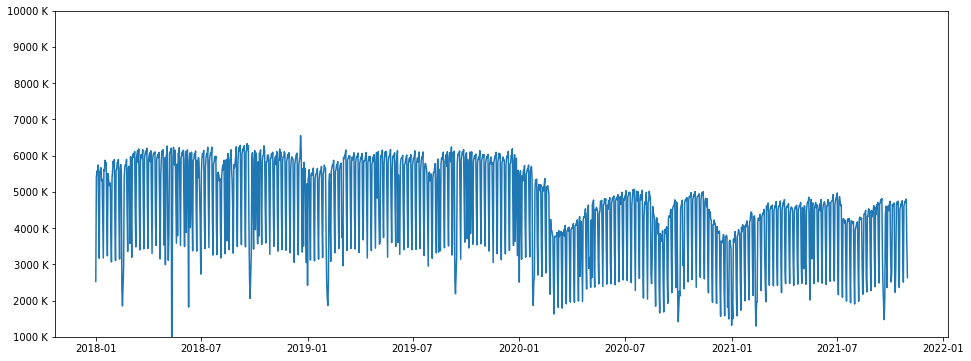

In [32]:
fig, ax = plt.subplots(figsize=(16,6))

ax.plot(user_per_date.사용일자, user_per_date.일별이용자수/1000, label='expoential')

plt.ylim([1000, 10000])
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%i K'))
leg = plt.legend()
ax.get_legend().remove()

plt.show() 

## 특이사항 확인

* 그래프를 보면 2018년 5월쯤 맨아래 가있는것을 확인함.

In [110]:
#날짜 확인
user_per_date[user_per_date["일별이용자수"] < 2000000]

,사용일자,일별이용자수
46,2018-02-16,1852188
131,2018-05-12,4042
160,2018-06-10,1819614
397,2019-02-05,1862627
751,2020-01-25,1864316
787,2020-03-01,1628751
794,2020-03-08,1813591
801,2020-03-15,1792128
808,2020-03-22,1909230
815,2020-03-29,1957319


In [54]:
#2018년 5월 12일 특이사항 확인
#2018년 데이터를 불러와 무슨일인지 확인
df2 = pd.read_parquet('./data/parquet/2018_bus_per_date.parquet')
df2

,사용일자,노선번호,노선명,버스정류장ARS번호,역명,승차총승객수,하차총승객수,등록일자
0,20180101,100,100번(하계동~용산구청),11428,한성여객종점,12,4,20180104
1,20180101,100,100번(하계동~용산구청),11387,노원평생학습관,11,0,20180104
2,20180101,100,100번(하계동~용산구청),11373,중계역,15,1,20180104
3,20180101,100,100번(하계동~용산구청),11381,중계시영4단지,97,13,20180104
4,20180101,100,100번(하계동~용산구청),11311,인덕대학,93,79,20180104
...,...,...,...,...,...,...,...,...
13748820,20181231,1144,1144번(하계동~삼양사거리),09102,우이동도선사입구.북한산우이역,19,171,20190103
13748821,20181231,1144,1144번(하계동~삼양사거리),09103,우이동성원아파트,7,37,20190103
13748822,20181231,1144,1144번(하계동~삼양사거리),09108,국립4.19민주묘지입구사거리,35,100,20190103
13748823,20181231,1144,1144번(하계동~삼양사거리),09106,서라벌중학교.우이동대우아파트,54,58,20190103


In [60]:
#2018년 5월12일 데이터
a = df2[df2["사용일자"] == 20180512]
a

,사용일자,노선번호,노선명,버스정류장ARS번호,역명,승차총승객수,하차총승객수,등록일자
4976867,20180512,100,100번(하계동~용산구청),11428,한성여객종점,6,0,20180515
4976868,20180512,100,100번(하계동~용산구청),11387,노원평생학습관,6,0,20180515
4976869,20180512,100,100번(하계동~용산구청),11374,서울시립북서울미술관,36,0,20180515
4976870,20180512,100,100번(하계동~용산구청),11373,중계역,34,7,20180515
4976871,20180512,100,100번(하계동~용산구청),11376,중계역2번출구,149,17,20180515
4976872,20180512,100,100번(하계동~용산구청),11378,중계3단지목련아파트,56,22,20180515
4976873,20180512,100,100번(하계동~용산구청),11380,중계시영3단지상가,228,58,20180515
4976874,20180512,100,100번(하계동~용산구청),11381,중계시영4단지,177,23,20180515
4976875,20180512,100,100번(하계동~용산구청),11438,노원경찰서,259,25,20180515
4976876,20180512,100,100번(하계동~용산구청),11436,하계1동주민센터,145,16,20180515


In [59]:
#2018년 5월12일에 100번버스 데이터만 있는것을 확인!
a.groupby("노선명").sum()

,사용일자,승차총승객수,하차총승객수,등록일자
노선명,,,,
100번(하계동~용산구청),484332288,4042,1976,484332360


In [67]:
#다른날짜랑 비교해보기
b = df2[df2["사용일자"] == 20180510]
b

,사용일자,노선번호,노선명,버스정류장ARS번호,역명,승차총승객수,하차총승객수,등록일자
4900390,20180510,421,421번(염곡동~옥수동),04119,마장축산물시장,270,107,20180513
4900391,20180510,100,100번(하계동~용산구청),11428,한성여객종점,11,5,20180513
4900392,20180510,421,421번(염곡동~옥수동),06164,동대문구청.용두역3번출구,258,289,20180513
4900393,20180510,100,100번(하계동~용산구청),11387,노원평생학습관,6,0,20180513
4900394,20180510,421,421번(염곡동~옥수동),06024,제기동역.서울약령시,341,549,20180513
...,...,...,...,...,...,...,...,...
4938614,20180510,9714,9714번(교하운정~서울역),63675,책향기마을,0,85,20180513
4938615,20180510,9714,9714번(교하운정~서울역),63660,중앙공원,0,38,20180513
4938616,20180510,9714,9714번(교하운정~서울역),63658,우리은행앞,2,119,20180513
4938617,20180510,9714,9714번(교하운정~서울역),63656,청석마을8단지,0,28,20180513


In [68]:
#2018년 5월10일에는 620개의 버스 데이터가 있는것을 확인.
b.groupby("노선명").sum()

,사용일자,승차총승객수,하차총승객수,등록일자
노선명,,,,
0017번(청암동~이촌동),827400910,6881,6727,827401033
02번(남산서울타워~동대입구),504512750,2449,2312,504512825
03번(남산서울타워~남산서울타워),464151730,1252,1169,464151799
05번(남산서울타워~남산서울타워),403610200,1537,1426,403610260
100번(하계동~용산구청),2441841710,20158,19383,2441842073
...,...,...,...,...
종로11(삼청동~서울역),423790710,3410,3293,423790773
종로12(서울대학교병원~종로3가),322888160,2972,2894,322888208
종로13(평창파출소~부암동주민센터.무계원),746678870,2131,2074,746678981


### 결론

* 확인을 해보니 2018년 5월12일에 100번 버스 데이터만 있음을 확인.
* 따라서 2018년 5월12일은 원본데이터가 잘못 되어 있으므로 2018년 5월 12일데이터를 삭제하기로 결정함.

In [73]:
user_per_date

,사용일자,일별이용자수
0,2018-01-01,2526585
1,2018-01-02,5401907
2,2018-01-03,5570015
3,2018-01-04,5547362
4,2018-01-05,5741154
...,...,...
1392,2021-10-27,4745936
1393,2021-10-28,4722851
1394,2021-10-29,4801950
1395,2021-10-30,3523511


In [91]:
#2018년 5월 12일 확인
c = user_per_date[user_per_date["일별이용자수"] == 4042]
c

,사용일자,일별이용자수
131,2018-05-12,4042


In [104]:
#2018년 5월 12일 삭제
user_per_date2 = user_per_date.drop(131).reset_index(drop=True)
user_per_date2

,사용일자,일별이용자수
0,2018-01-01,2526585
1,2018-01-02,5401907
2,2018-01-03,5570015
3,2018-01-04,5547362
4,2018-01-05,5741154
...,...,...
1391,2021-10-27,4745936
1392,2021-10-28,4722851
1393,2021-10-29,4801950
1394,2021-10-30,3523511


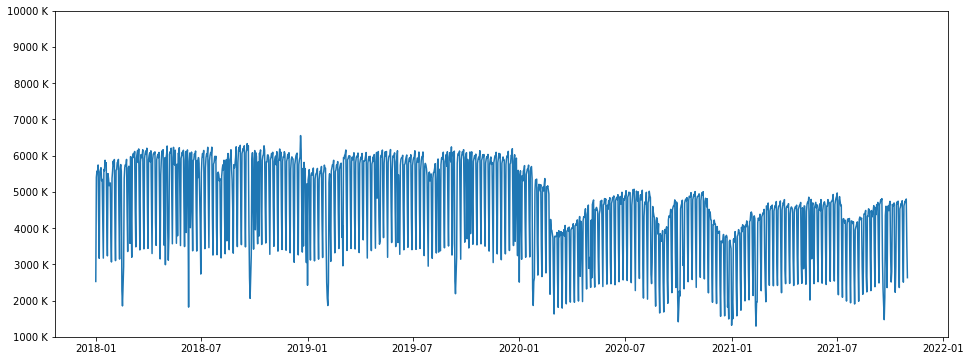

In [106]:
#그래프 다시 확인
fig, ax = plt.subplots(figsize=(16,6))

ax.plot(user_per_date2.사용일자, user_per_date2.일별이용자수/1000, label='expoential')

plt.ylim([1000, 10000])
plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%i K'))
leg = plt.legend()
ax.get_legend().remove()

plt.show() 

In [105]:
#parquet 저장
user_per_date2.to_parquet("bus_main.parquet")